<a href="https://colab.research.google.com/github/dauparas/pytorch_examples/blob/master/GAN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning about GANs
http://www.nowozin.net/sebastian/talks/mlss2018/MLSS%202018%20-%20Nowozin%20-%20GANs%20introduction.pdf

https://www.youtube.com/watch?v=knuq6qMDfrs

https://github.com/nowozin/mlss2018-madrid-gan

## GAN Example: Univariate Density Estimation

* _Author_: Sebastian Nowozin (Sebastian.Nowozin@microsoft.com)
* _Date_: 16th July 2018

In [0]:
import math
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [0]:
df = 40.0
tdist = scipy.stats.t(df)

Generate training data

In [0]:
ntrain = 5000
Xtrain = tdist.rvs(ntrain)

Plot the training data and the true _probability density function_ (pdf).

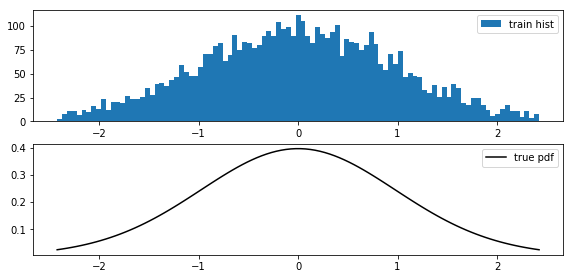

In [21]:
fig, ax = plt.subplots(2,1, figsize=(9.5,4.5))
xmin = tdist.ppf(0.01)
xmax = tdist.ppf(0.99)
xs = np.linspace(tdist.ppf(0.01), tdist.ppf(0.99), 100)
ax[0].hist(Xtrain, xs, label="train hist")
ax[0].legend()
ax[1].plot(xs, tdist.pdf(xs), 'k-', lw=1.5, label="true pdf")
ax[1].legend();

## GAN Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [0]:
class ConjugateDualFunction:
    def __init__(self, divergence_name):
        self.divergence_name = divergence_name

    def T(self, v):
        """Compute T(v) repersentation
        
        Arguments
        v -- The scalar output (full real number range) of the discriminator
        """
        if self.divergence_name == "kl":
            return v
        elif self.divergence_name == "klrev":
            return -F.exp(v)
        elif self.divergence_name == "pearson":
            return v
        elif self.divergence_name == "neyman":
            return 1.0 - F.exp(v)
        elif self.divergence_name == "hellinger":
            return 1.0 - F.exp(v)
        elif self.divergence_name == "jensen":
            return math.log(2.0) - F.softplus(-v)
        elif self.divergence_name == "gan":
            return -F.softplus(-v)
        else:
            raise ValueError("Unknown divergence name in t function.")

    def fstarT(self, v):
        """Compute the f^*(T(v)) representation
        
        Arguments
        v -- The scalar output of the variational function neural network.
        """
        if self.divergence_name == "kl":
            return torch.exp(v - 1.0)
        elif self.divergence_name == "klrev":
            return -1.0 - v
        elif self.divergence_name == "pearson":
            return 0.25*v*v + v
        elif self.divergence_name == "neyman":
            return 2.0 - 2.0*F.exp(0.5*v)
        elif self.divergence_name == "hellinger":
            return F.exp(-v) - 1.0
        elif self.divergence_name == "jensen":
            return F.softplus(v) - math.log(2.0)
        elif self.divergence_name == "gan":
            return F.softplus(v)
        else:
            raise ValueError("Unknown divergence name in fstar_t function.")

In [0]:
class Generator(nn.Module):
    def __init__(self, nhidden):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(1, nhidden)
        self.lin2 = nn.Linear(nhidden, 1)

    def forward(self, z):
        h = F.relu(self.lin1(z))
        x = self.lin2(h)
        return x

class Discriminator(nn.Module):
    def __init__(self, nhidden):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(1, nhidden)
        self.lin2 = nn.Linear(nhidden, 1)

    def forward(self, x):
        h = F.relu(self.lin1(x))
        v = self.lin2(h)
        return v

In [0]:
class FGANLearningObjective(nn.Module):
    def __init__(self, gen, disc, divergence_name="gan", gamma=10.0):
        super(FGANLearningObjective, self).__init__()
        self.gen = gen
        self.disc = disc
        self.conj = ConjugateDualFunction(divergence_name)
        self.gammahalf = 0.5*gamma

    def forward(self, xreal, zmodel):
        # Real data
        vreal = self.disc(xreal)    # Real data discriminator output
        Treal = self.conj.T(vreal)  # Mapped to T-space

        # Model data
        xmodel = self.gen(zmodel)   # Map noise to data
        vmodel = self.disc(xmodel)  # Model data discriminator output
        fstar_Tmodel = self.conj.fstarT(vmodel)   # Mapped to f^*(T)

        # Compute generator loss
        loss_gen = -fstar_Tmodel.mean()

        # Compute discriminator loss (negation because we minimize)
        loss_disc = fstar_Tmodel.mean() - Treal.mean()

        # Compute gradient penalty as per (Mescheder et al., ICML 2018)
        if self.gammahalf > 0.0:
            batchsize = xreal.size(0)
            grad_pd = torch.autograd.grad(Treal.sum(), xreal,
                create_graph=True, only_inputs=True)[0]
            grad_pd_norm2 = grad_pd.pow(2)
            grad_pd_norm2 = grad_pd_norm2.view(batchsize, -1).sum(1)
            gradient_penalty = self.gammahalf * grad_pd_norm2.mean()
            loss_disc += gradient_penalty

        return loss_gen, loss_disc

In [0]:
gen = Generator(64)
disc = Discriminator(64)
fgan = FGANLearningObjective(gen, disc, "gan", gamma=1.0)

In [0]:
batchsize = 256
optimizer_gen = optim.Adam(fgan.gen.parameters(), lr=1.0e-3)
optimizer_disc = optim.Adam(fgan.disc.parameters(), lr=1.0e-3)

In [28]:
niter = 15000
for i in range(niter):
    fgan.zero_grad()

    # Generate real data (from known distribution) and noise
    xreal = Variable(torch.Tensor(np.reshape(tdist.rvs(batchsize),
        (batchsize,1))), requires_grad=True)
    zmodel = Variable(torch.rand((batchsize,1)))

    loss_gen, loss_disc = fgan(xreal, zmodel)
    if i % 1000 == 1:
        print("iter %d  obj(D) %.4f  obj(G) %.4f" % (i, loss_disc, loss_gen))

    fgan.gen.zero_grad()
    loss_gen.backward(retain_graph=True)
    optimizer_gen.step()

    fgan.disc.zero_grad()
    loss_disc.backward()
    optimizer_disc.step()

iter 1  obj(D) 1.4070  obj(G) -0.6900
iter 1001  obj(D) 1.3030  obj(G) -0.5303
iter 2001  obj(D) 1.3663  obj(G) -0.6942
iter 3001  obj(D) 1.3674  obj(G) -0.6815
iter 4001  obj(D) 1.4045  obj(G) -0.7357
iter 5001  obj(D) 1.3440  obj(G) -0.6783
iter 6001  obj(D) 1.4007  obj(G) -0.7647
iter 7001  obj(D) 1.3749  obj(G) -0.6617
iter 8001  obj(D) 1.3764  obj(G) -0.6629
iter 9001  obj(D) 1.3838  obj(G) -0.7196
iter 10001  obj(D) 1.3837  obj(G) -0.7019
iter 11001  obj(D) 1.3707  obj(G) -0.6243
iter 12001  obj(D) 1.3700  obj(G) -0.6826
iter 13001  obj(D) 1.4008  obj(G) -0.7047
iter 14001  obj(D) 1.3944  obj(G) -0.7214


## Visualize model results

In [0]:
n = 4096
Xmodel = fgan.gen(Variable(torch.rand((n,1)), requires_grad=False)).detach().cpu()
Xmodel = Xmodel.numpy()

In [0]:
xmin = min(np.percentile(Xmodel, 1.0), tdist.ppf(0.01))
xmax = max(np.percentile(Xmodel, 99.0), tdist.ppf(0.99))
nbins = 100
xs = np.linspace(xmin, xmax, nbins)
ydisc = fgan.disc(Variable(torch.Tensor(np.reshape(xs, (nbins,1)))))
ydisc = ydisc.detach().cpu().numpy()

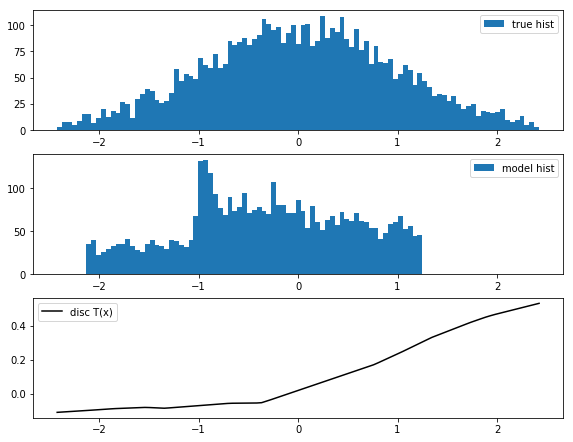

In [31]:
fig, ax = plt.subplots(3,1,figsize=(9.5,7.5))
ax[0].hist(tdist.rvs(ntrain), xs, label="true hist")
ax[0].legend()
ax[1].hist(Xmodel, xs, label="model hist")
ax[1].legend()
ax[2].plot(xs, ydisc, "k-", label="disc T(x)")
ax[2].legend();